In [22]:
import torch
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html

Looking in links: https://pytorch-geometric.com/whl/torch-.html

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Looking in links: https://pytorch-geometric.com/whl/torch-.html

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Looking in links: https://pytorch-geometric.com/whl/torch-.html

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Looking in links: https://pytorch-geometric.com/whl/torch-.html

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [23]:
!pip install torch-geometric
!pip install torch-geometric-temporal
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [24]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

print("Dataset type: ", dataset)

#no direct len() function available for object dataset and converting in set is not possible because of unhashable data type
num_samples = 0
for data in dataset:
    num_samples += 1
print("Number of samples/ sequences: ", num_samples)

Dataset type:  <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7fcfe802bfa0>
Number of samples/ sequences:  34249


In [25]:
#sample data
first_data = next(iter(dataset))
print(first_data)
#data need not be the same as previous node
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
d = ChickenpoxDatasetLoader().get_dataset(lags=4)
next(iter(d))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])

No handles with labels found to put in legend.


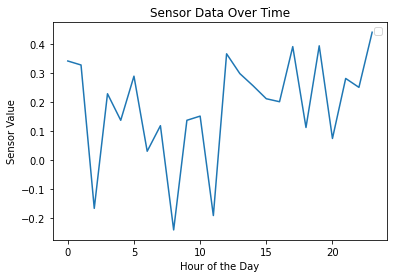

In [26]:
#simple visualization of the given data over time (hours of a day)
import seaborn as sns
import matplotlib.pyplot as plt

sensor_number = 10
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]

hours_list = list(range(hours))
sns.lineplot(x=hours_list, y=sensor_labels)
plt.xlabel("Hour of the Day")
plt.ylabel("Sensor Value")
plt.title("Sensor Data Over Time")
plt.legend()
plt.show()

In [27]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

train_count= 0
for data in train_dataset:
    train_count+= 1
test_count= 0
for data in test_dataset:
    test_count+= 1
print("Number of train buckets: ", train_count)
print("Number of test buckets: ", test_count)

Number of train buckets:  27399
Number of test buckets:  6850


In [36]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=64,
                           periods=periods)  #input layer
        self.linear1 = torch.nn.Linear(64, 128)  #hidden layer 1
        self.linear2 = torch.nn.Linear(128, 256)  #hidden layer 2
        self.linear3 = torch.nn.Linear(256, 128)  #hidden layer 3
        self.linear4 = torch.nn.Linear(128, 64)   #hidden layer 4
        self.output_layer = torch.nn.Linear(64, periods)

    def forward(self, x, edge_index):
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        #passes through 2 fully connected hidden layers this time
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        h = F.relu(h)
        h = self.linear3(h)
        h = F.relu(h)
        h = self.linear4(h)
        h = F.relu(h)
        h = self.output_layer(h)  #output layer
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 64)
      (linear_z): Linear(in_features=128, out_features=64, bias=True)
      (conv_r): GCNConv(2, 64)
      (linear_r): Linear(in_features=128, out_features=64, bias=True)
      (conv_h): GCNConv(2, 64)
      (linear_h): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (linear1): Linear(in_features=64, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=12, bias=True)
)

In [37]:
device = torch.device('cpu')
subset = 3000

#model created and optimization
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Training of the model")
for epoch in range(10):
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        #get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        #mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2)
        step += 1
        if step > subset:
            break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Training of the model
Epoch 0 train MSE: 0.9996
Epoch 1 train MSE: 0.9939
Epoch 2 train MSE: 0.9823
Epoch 3 train MSE: 0.9374
Epoch 4 train MSE: 0.8305
Epoch 5 train MSE: 0.7290
Epoch 6 train MSE: 0.7540
Epoch 7 train MSE: 0.6285
Epoch 8 train MSE: 0.6564
Epoch 9 train MSE: 0.6568


In [38]:
model.eval()
loss = 0
step = 0
horizon = 288

#storing results
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    y_hat = model(snapshot.x, snapshot.edge_index)
    #mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    #storing results
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss/ (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))
     

Test MSE: 0.6884


In [39]:
sensor = 100
timestep = 10
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (289,)


<AxesSubplot:>

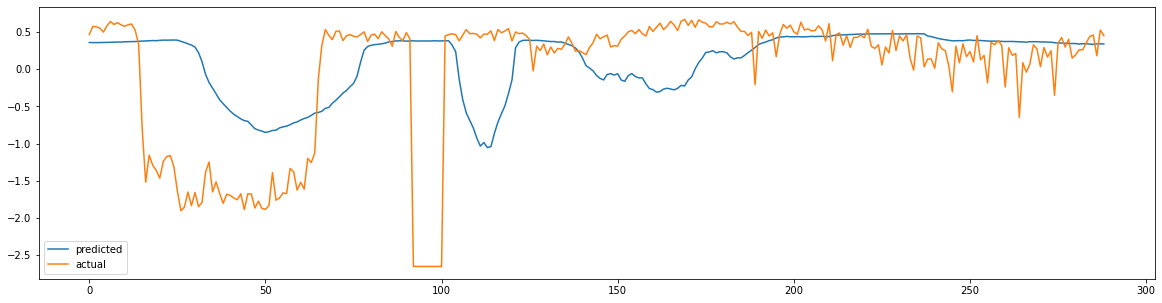

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="predicted")
sns.lineplot(data=labs, label="actual")